# Video color sheme demo


Analyze the color scheme of the video frame using the clustering algorithm and create an image based on this color scheme

### Imports

In [1]:
import os
from collections import Counter

import cv2
import numpy as np
import moviepy.editor as mp
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle

### Parameters

In [2]:
video_path = 'videos/batman.mp4'  # path to the video to process
number_of_colors = 5  # number of colors to detect

## Analyse color sheme of a video frame

In [3]:
# helper function to convert RGB color to HEX
def rgb_to_hex(rgb_color):
    hex_color = "#"
    for i in rgb_color:
        hex_color += ("{:02x}".format(int(i)))
    return hex_color

In [4]:
# read a video
video = mp.VideoFileClip(video_path)

In [5]:
image = video.get_frame(6)  # get an image from the sixth second

(-0.5, 1279.5, 719.5, -0.5)

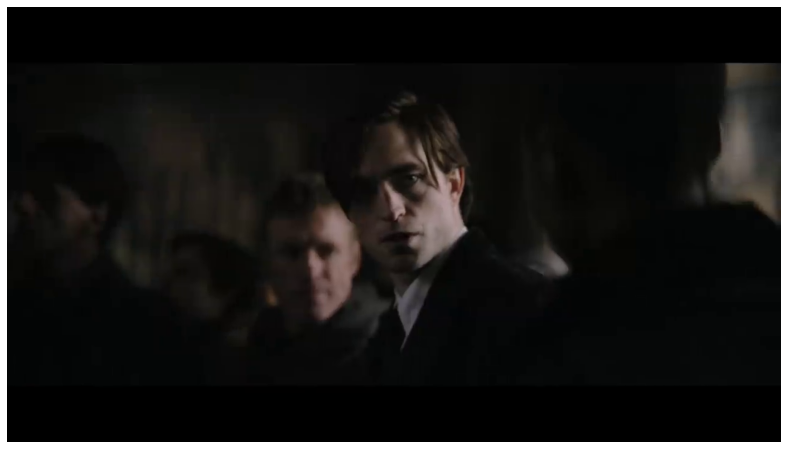

In [6]:
plt.figure(figsize=(14, 8))
plt.imshow(image)
plt.axis('off')

In [7]:
image.shape

(720, 1280, 3)

In [8]:
# resize the image to speed up the analysis
image = cv2.resize(image, (300, 300))

(-0.5, 299.5, 299.5, -0.5)

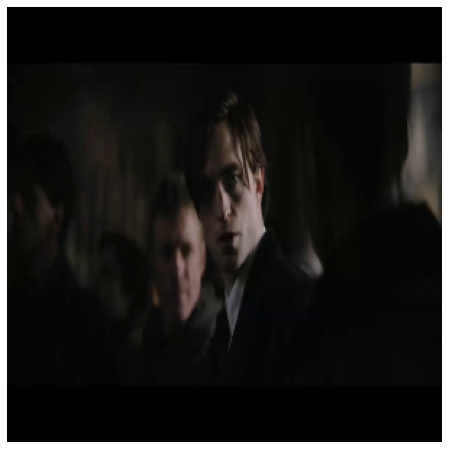

In [9]:
plt.figure(figsize=(14, 8))
plt.imshow(image)
plt.axis('off')

In [10]:
image.shape

(300, 300, 3)

In [11]:
# reshape image because KMeans expects 2D array
image = image.reshape(image.shape[0]*image.shape[1], 3)
image.shape

(90000, 3)

In [12]:
# train clustering algorithm that can learn information about centroids
# can be also MeanShift, Affinity Propagation, etc.

clustering = KMeans(n_clusters=number_of_colors)

# clustering prediction for each pixel
color_labels = clustering.fit_predict(image)
# coordinates of the cluster centroids
center_colors = clustering.cluster_centers_

In [13]:
center_colors

array([[  1.7868352 ,   2.4462862 ,   2.37420527],
       [136.24350837, 115.19215234, 110.60703982],
       [ 11.06580217,  11.23287555,   9.88252653],
       [ 32.82805693,  28.90899409,  24.95188305],
       [ 77.56437908,  67.11503268,  61.43921569]])

In [14]:
# the number of times each colors occurs on the image
color_counts = Counter(color_labels)
color_counts

Counter({0: 39636, 2: 35236, 3: 10320, 4: 3068, 1: 1740})

In [15]:
# sum of the counter values is image size
total = sum(color_counts.values())
total

90000

In [16]:
ordered_colors = [center_colors[idx]
                  for idx in color_counts.keys()]  # colors ordered by popularity
hex_colors = [(rgb_to_hex(ordered_colors[idx]), value/total)
              for idx, value in color_counts.items()]

In [17]:
hex_colors

# list of tuples, that contains color and it's ratio on the image
# sorted by popularity

[('#010202', 0.4404),
 ('#201c18', 0.3915111111111111),
 ('#4d433d', 0.11466666666666667),
 ('#88736e', 0.03408888888888889),
 ('#0b0b09', 0.019333333333333334)]

If we wrap the code above into functions, we will get the following:

In [18]:
def preprocess(image, compress_to=500):
    # resize the image to speed up the analysis
    image = cv2.resize(image, (compress_to, compress_to))
    # reshape image because KMeans expects 2D array
    image = image.reshape(image.shape[0]*image.shape[1], 3)
    return image

In [19]:
def analyze_colors(image, number_of_colors=5):
    clustering = KMeans(n_clusters=number_of_colors)
    color_labels = clustering.fit_predict(image)  # clustering prediction for each pixel
    center_colors = clustering.cluster_centers_  # coordinates of the cluster centroids
    
    color_counts = Counter(color_labels)  # the number of times each colors occurs on the image
    total = sum(color_counts.values())
    # colors ordered by popularity
    ordered_colors = [center_colors[idx] 
                      for idx in color_counts.keys()]  
    hex_colors = [(rgb_to_hex(ordered_colors[idx]), value/total) 
                  for idx, value in color_counts.items()]
    hex_colors_only = [turple[0] for turple in hex_colors]

    plt.figure(figsize=(12, 8))
    plt.pie(color_counts.values(), labels=hex_colors_only, colors=hex_colors_only)
    
    print(f"Found the following top-{number_of_colors} colors:")
    for color, ratio in hex_colors:
        print(f"\t{color} - {ratio*100:.2f}%")

In [20]:
image = video.get_frame(6)

modified_image = preprocess(image)

Found the following top-5 colors:
	#010202 - 44.13%
	#87726d - 38.89%
	#0b0b09 - 11.55%
	#4c423c - 3.44%
	#201c18 - 1.98%


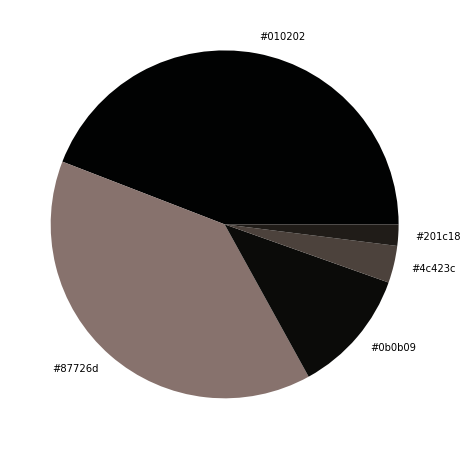

In [21]:
analyze_colors(modified_image, number_of_colors)

# Draw a result image

In [22]:
hex_colors

[('#010202', 0.4404),
 ('#201c18', 0.3915111111111111),
 ('#4d433d', 0.11466666666666667),
 ('#88736e', 0.03408888888888889),
 ('#0b0b09', 0.019333333333333334)]

In [23]:
# for simplicity let's define colors array explicitly
colors = [color_tuple[0] for color_tuple in hex_colors]
colors

['#010202', '#201c18', '#4d433d', '#88736e', '#0b0b09']

In [24]:
def compose_result_image(result_colors, width, height):
    total_colors = len(result_colors)
    rectangle_width = width/total_colors

    fig, ax = plt.subplots(figsize=(width, height))
    # draw two invisible lines that define the size of the canvas
    ax.plot([0, width], [height, height], linewidth=0)
    ax.plot([0, width], [0, 0], linewidth=0)

    for i, color in enumerate(result_colors):
        # Rectangle parameters:
        # - xy: The (x, y) coordinates for the anchor point of the rectangle
        # - width: Rectangle width
        # - height: Rectangle height
        ax.add_patch(Rectangle((i*rectangle_width, 0),
                     rectangle_width, height, color=color))

    plt.axis('off')
    plt.margins(x=0, y=0)  # remove blank space around the plot
    # plt.savefig('result_image.png', dpi=300, bbox_inches='tight')
    plt.show()

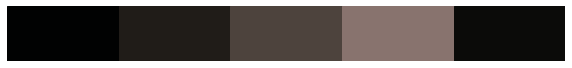

In [25]:
compose_result_image(colors, width=10, height=1)

In [26]:
# let's generate a lot of random HEX colors
import random
n = 60*90  # every second in 90-minutes video
colors = ["#%06x" % random.randint(0, 0xFFFFFF) for _ in range(n)]

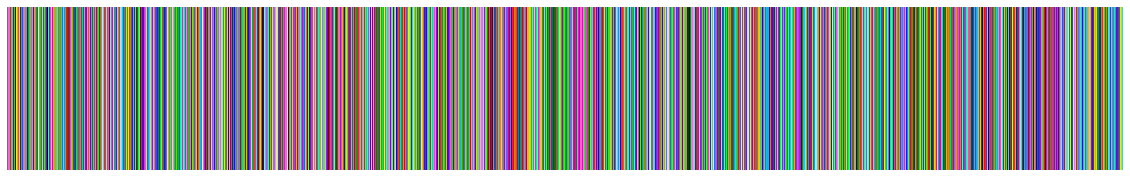

In [27]:
compose_result_image(colors, width=20, height=3)